In [1]:
%matplotlib inline
from category_tree import CategoryTree

import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage
from keras.datasets import cifar10
import keras.utils as Kutils

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend import set_session,tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)) #利用量に合わせて確保
config.gpu_options.per_process_gpu_memory_fraction = 0.49 # 上限を0.2に抑える(optional)
set_session(tf.Session(config=config))

In [3]:
result_dir = './'

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
nclasses = 10

LEAF = None

# hierarchy for cifar10
category_tree={
      "transport": 
         {  "airplane":LEAF, 
             "automobile":{ # note that automobile has only one child, a counter class is automatically filled lator.
                "truck":LEAF}, 
             "ship":LEAF}
      ,
      "animal": {
           "bird":LEAF, 
           "frog":LEAF, 
           "mammal": {
               "deer": LEAF,
               "dog": LEAF,
               "cat": LEAF,
               "horse": LEAF
           }
       } 
}



(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [5]:
# debug code (tree construction and prediction)

cat_tree = CategoryTree(category_tree)
#cat_tree.print_debug()
predictions_dummy = np.array([0.1,0.9]+[0.3,0.3,0.4]+[0.05,0.9,0.05]+[0.1,0.0,0.85,0.05]+[0.2,0.8])

# functions to evaluate/analyze results
top_cat, prob = cat_tree.hierarchy_top_prediction(predictions_dummy, 0.1)
print(cat_tree.decode(top_cat),": %f"%prob)
print([cat_tree.get_hierarchy_probability(predictions_dummy,cat) for cat in range(cat_tree.nlabels)])
print(cat_tree.hierarchy_predictions(predictions_dummy))


truck : 0.648000
[0.10000000000000001, 0.90000000000000002, 0.029999999999999999, 0.029999999999999999, 0.040000000000000008, 0.045000000000000005, 0.81000000000000005, 0.045000000000000005, 0.004000000000000001, 0.0, 0.034000000000000002, 0.0020000000000000005, 0.16200000000000003, 0.64800000000000013]
[ 0.1    0.9    0.03   0.03   0.04   0.045  0.81   0.045  0.004  0.     0.034
  0.002  0.162  0.648]


In [6]:
# debug code (n hot vector conversion)

# original labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
# tree labels:     ['animal' 'transport' 'bird' 'frog' 'mammal' 'airplane' 'automobile' 'ship' 'cat' 'deer' 'dog' 'horse' 'automobile' 'truck']
print(cat_tree.labels)

lut4conv = [5, 12, 2, 8, 9, 10, 3, 11,7,13] # lookup table that convert original labels to tree label leaves. 
# note that 'automobile' is not 6 because label 6 is not a leaf.

n_hot_vectors = cat_tree.to_hierarchical_categorical(np.array([[2],[3],[6],[1],[3],[5],[9]]), lut4conv)
print(n_hot_vectors)


['animal' 'transport' 'bird' 'frog' 'mammal' 'airplane' 'automobile' 'ship'
 'cat' 'deer' 'dog' 'horse' 'automobile' 'truck']
[[ 1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]]


In [7]:
def plot_cifar10(X_train, y_train, result_dir):
    # CIFAR-10データセットをロード
    # 画像を描画
    pos = 1
    for targetClass in range(nclasses):
        targetIdx = []
        # クラスclassIDの画像のインデックスリストを取得
        for i in range(len(y_train)):
            if y_train[i][0] == targetClass:
                targetIdx.append(i)

        # 各クラスからランダムに選んだ最初の10個の画像を描画
        np.random.shuffle(targetIdx)
        for idx in targetIdx[:10]:
            img = toimage(X_train[idx])
            plt.subplot(10, 10, pos)
            plt.imshow(img)
            plt.axis('off')
            pos += 1

    plt.show()

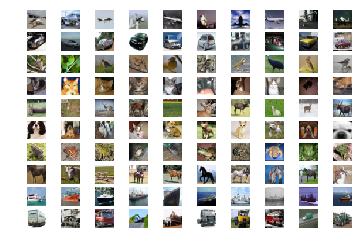

In [8]:
# 入力画像の次元
img_rows, img_cols = 32, 32

# チャネル数（RGBなので3）
img_channels = 3

# CIFAR-10データをロード
# (nb_samples, nb_rows, nb_cols, nb_channel) = tf
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# ランダムに画像をプロット
plot_cifar10(X_train, y_train, result_dir)

# 画素値を0-1に変換
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0



In [9]:
# クラスラベル（0-9）をone-hotエンコーディング形式に変換
#y_train = Kutils.to_categorical(y_train, nclasses)
#y_test = Kutils.to_categorical(y_test, nclasses)
# クラスラベル（0-9）を n-hot エンコーディング形式に変換
y_train = cat_tree.to_hierarchical_categorical(y_train, lut4conv)
y_test = cat_tree.to_hierarchical_categorical(y_test, lut4conv)


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization

# CNNを構築
model = Sequential()

# オリジナルのcifar10用モデルからの変更点
# 1. BatchNormalizationをしてみる．
# 2. loss関数をtriplet lossにしてみる.
model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(cat_tree.nclasses)) # CAUTION: here, ncalsses is not 10!!
#model.add(Activation('softmax',name='predictions'))
model.add(Activation(cat_tree.hierarchical_softmax,name='predictions')) # CAUTION: you must use hierarchical_softmax!

model.compile(loss=cat_tree.generate_loss_func(), # CAUTION: you must use a loss function generated by cat tree.
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
__________

In [12]:
from keras.preprocessing.image import ImageDataGenerator
epochs=30
data_augmentation = True
batch_size=128
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

    
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using real-time data augmentation.
Epoch 1/30
390/390 [==============================] - 20s - loss: 230.5028 - acc: 0.6571 - val_loss: 288.8147 - val_acc: 0.6309
Epoch 2/30
390/390 [==============================] - 18s - loss: 177.1447 - acc: 0.7092 - val_loss: 159.4329 - val_acc: 0.7671
Epoch 3/30
390/390 [==============================] - 18s - loss: 155.2049 - acc: 0.7099 - val_loss: 137.4258 - val_acc: 0.7353
Epoch 4/30
390/390 [==============================] - 17s - loss: 140.2692 - acc: 0.7170 - val_loss: 175.7866 - val_acc: 0.6461
Epoch 5/30
390/390 [==============================] - 18s - loss: 130.0665 - acc: 0.7241 - val_loss: 149.7451 - val_acc: 0.7922
Epoch 6/30
390/390 [==============================] - 18s - loss: 123.0334 - acc: 0.7270 - val_loss: 122.7132 - val_acc: 0.7691
Epoch 7/30
390/390 [==============================] - 18s - loss: 117.1083 - acc: 0.7176 - val_loss: 138.7716 - val_acc: 0.6978
Epoch 8/30
390/390 [==============================] - 17s - loss: 113

In [13]:
model_file_basename = "%shierarchical_no_data_augumentation"%(result_dir)
model.save_weights(model_file_basename+".hdf5")
print("save to %s"%model_file_basename+".hdf5")

save to ./hierarchical_no_data_augumentation.hdf5


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


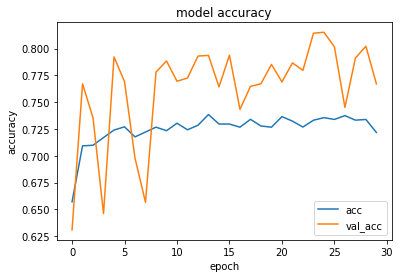

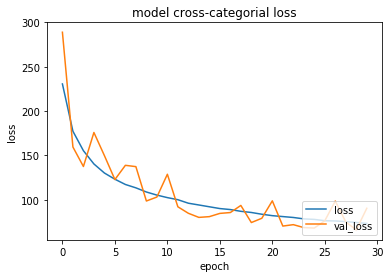

In [14]:
def plot_history(history):
    print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.savefig(model_file_basename+".acc.png")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model cross-categorial loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.savefig(model_file_basename+".loss.png")
    plt.show()

print(history)
# 学習履歴をプロット
plot_history(history)

In [24]:
y_pred = model.predict(X_test)
def get_label(n_hot_vector):
    return cat_tree.decode(np.where(n_hot_vector==1)[0][-1])
    
def print_labels(_y_pred,thresholds, y_true):
    labels = []
    y_true = get_label(y_true)
    for th in thresholds:
        cat, prob = cat_tree.hierarchy_top_prediction(_y_pred, th)
        if cat==None:          
            continue
        label = cat_tree.decode(cat)
        labels.append("%s(%f)"%(label,prob))
    if len(labels)==0:
        # failed to predict label at the top level categories
        print("[%s]: "%y_true)
        return
    label = labels[0][0]
    if len(labels)==len(thresholds) and np.all([l[0]==label for l in labels]):
        return
    labels = [l for l,l2 in zip(labels,labels[1:]+[None]) if l!=l2]
    print("[%s]: "%y_true, "\t".join(labels))

step = 0.1
thresholds = np.arange(0.50,1.0+step,step)
for i in range(1000):
    print_labels(y_pred[i],thresholds, y_test[i])

[cat]:  dog(0.619373)	mammal(0.994636)
[ship]:  ship(0.842327)	transport(0.999989)
[ship]:  ship(0.901400)
[airplane]:  ship(0.550586)	transport(0.873294)
[frog]:  frog(0.999614)
[frog]:  frog(0.656451)	animal(0.999995)
[automobile]:  automobile(0.888881)
[frog]:  frog(0.993025)
[cat]:  cat(0.975765)
[automobile]:  automobile(0.714441)	automobile(0.988875)
[airplane]:  mammal(0.799496)	animal(0.832976)
[truck]:  truck(0.999988)	automobile(1.000000)
[dog]:  dog(0.852340)	mammal(0.968542)
[horse]:  horse(0.995603)
[truck]:  truck(0.999283)	transport(1.000000)
[ship]:  frog(0.994848)
[dog]:  dog(0.983612)
[horse]:  horse(0.958356)
[ship]:  ship(1.000000)	transport(1.000000)
[frog]:  frog(0.999997)	animal(1.000000)
[horse]:  horse(0.915246)
[airplane]:  airplane(0.697245)	transport(0.723262)
[deer]:  deer(0.854505)
[truck]:  truck(0.999906)	automobile(1.000000)
[dog]:  dog(0.741169)	mammal(0.992086)
[bird]:  mammal(0.759685)	animal(0.989501)
[deer]:  deer(0.664421)	mammal(0.979234)
[airpla

[dog]:  dog(0.800619)	mammal(0.997544)
[ship]:  ship(0.957527)
[dog]:  dog(0.994036)
[deer]:  deer(0.744857)	mammal(0.998331)
[frog]:  frog(0.986738)
[ship]:  ship(0.813863)
[truck]:  truck(0.973323)
[truck]:  truck(0.999951)	automobile(1.000000)
[automobile]:  automobile(0.999328)
[airplane]:  ship(0.837876)	transport(0.999953)
[bird]:  bird(0.964065)
[bird]:  animal(1.000000)
[horse]:  mammal(0.672623)	animal(0.999958)
[cat]:  mammal(0.880245)	animal(0.999945)
[bird]:  mammal(0.675540)	animal(0.998774)
[ship]:  ship(0.894405)	transport(0.978604)
[airplane]:  airplane(0.983488)
[truck]:  truck(0.999620)
[dog]:  dog(0.992200)
[ship]:  ship(0.971478)
[automobile]:  automobile(0.926771)
[truck]:  truck(0.999982)
[deer]:  mammal(0.844494)	animal(0.965830)
[automobile]:  automobile(0.936033)
[cat]:  cat(0.597181)	mammal(0.816958)	animal(0.995577)
[ship]:  deer(0.747014)	animal(0.804035)
[automobile]:  automobile(0.940521)	automobile(1.000000)
[deer]:  cat(0.883335)	mammal(0.986843)
[horse]

[truck]:  truck(0.996795)
[truck]:  automobile(0.643356)	transport(0.959113)
[deer]:  frog(0.597312)	animal(0.999574)
[automobile]:  automobile(0.908711)
[deer]:  deer(0.611268)	mammal(0.858292)	animal(0.973651)
[automobile]:  automobile(0.997626)
[cat]:  dog(0.622062)	mammal(0.933460)
[bird]:  dog(0.654799)	mammal(0.979856)
[horse]:  horse(0.999732)
[airplane]:  transport(0.976212)
[horse]:  horse(0.976520)
[truck]:  animal(0.502625)
[horse]:  horse(0.989218)
[frog]:  mammal(0.695233)	animal(0.999984)
[frog]:  frog(0.999986)	animal(1.000000)
[bird]:  bird(0.657743)	animal(0.999806)
[dog]:  cat(0.733298)	mammal(0.999966)
[truck]:  truck(0.999924)
[bird]:  airplane(0.618300)
[truck]:  truck(0.987223)
[automobile]:  automobile(0.997391)	transport(1.000000)
[bird]:  bird(0.898217)	animal(0.999599)
[bird]:  bird(0.805835)	animal(0.999112)
[frog]:  frog(0.997296)
[ship]:  ship(0.999997)
[bird]:  bird(0.998579)
[automobile]:  automobile(0.999971)	automobile(1.000000)
[cat]:  cat(0.799541)	ma